In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, probplot, t, gaussian_kde
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_tables = pd.read_html(sp500_url)
sp500_df = sp500_tables[0]
tickers = sp500_df['Symbol'].tolist()
tickers = [ticker.replace('.', '-') for ticker in tickers]
print(f"Number of tickers in SP500 universe: {len(tickers)}")
data = pd.read_parquet('sp500_10yr_daily.parquet')

# Fill missing values with forward fill method to preserve more data
data = data.ffill()
print(len(data))

# Calculate log returns
returns = np.log(data / data.shift(1))
print(len(returns))

Number of tickers in SP500 universe: 503
2515
2515


Number of tickers in SP500 universe: 503
2515
2515


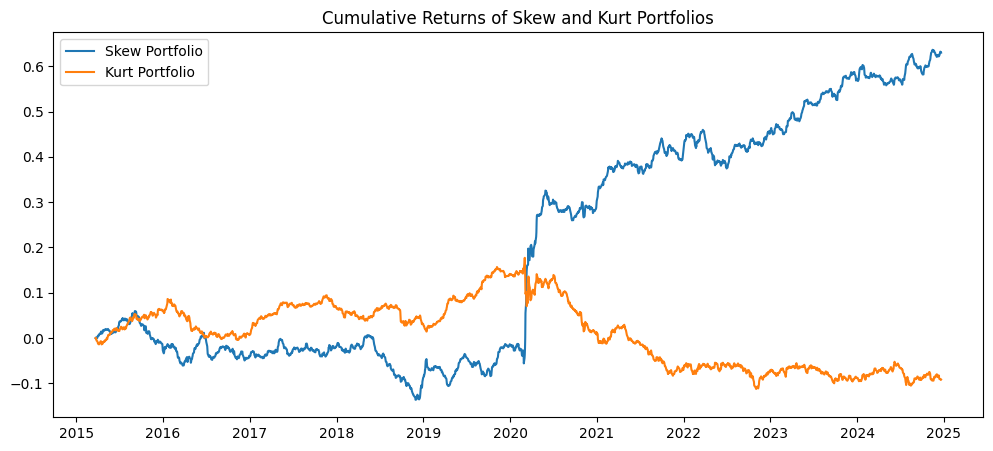


Annualized Performance Metrics: Skew Portfolio
Annualized Return: 0.064636
Annualized Volatility: 0.055107
Annualized Sharpe Ratio: 0.447052

Annualized Performance Metrics: Kurtosis Portfolio
Annualized Return: -0.009408
Annualized Volatility: 0.044923
Annualized Sharpe Ratio: -1.099831

--- Analysis: Skew Portfolio Returns ---
Shapiro-Wilk Test (Normality): Statistic=0.8096, p-value=4.143e-47
Fitted t-distribution parameters (Skew Portfolio):
Degrees of freedom, location, scale = (np.float64(2.1093658799893458), np.float64(2.258173806120072e-05), np.float64(0.0019149779925830145))

ADF Test (Skew Portfolio Returns):
Test Statistic: -8.9787, p-value=7.411e-15


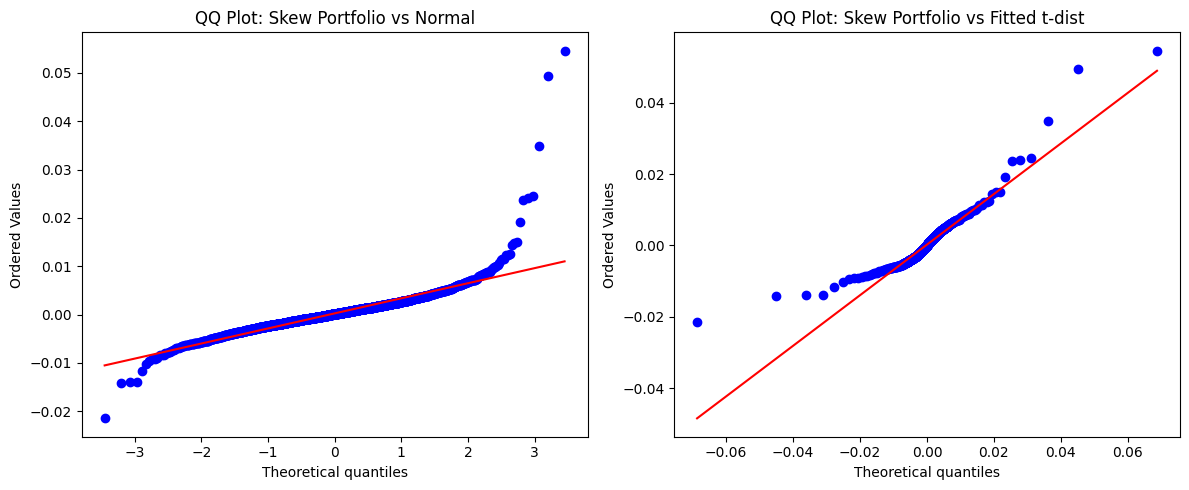


--- Analysis: Kurt Portfolio Returns ---
Shapiro-Wilk Test (Normality): Statistic=0.8672, p-value=1.691e-41
Fitted t-distribution parameters (Kurt Portfolio):
Degrees of freedom, location, scale = (np.float64(2.0160769194131207), np.float64(-7.71703347325086e-05), np.float64(0.0016237964151172542))

ADF Test (Kurt Portfolio Returns):
Test Statistic: -8.5701, p-value=8.241e-14


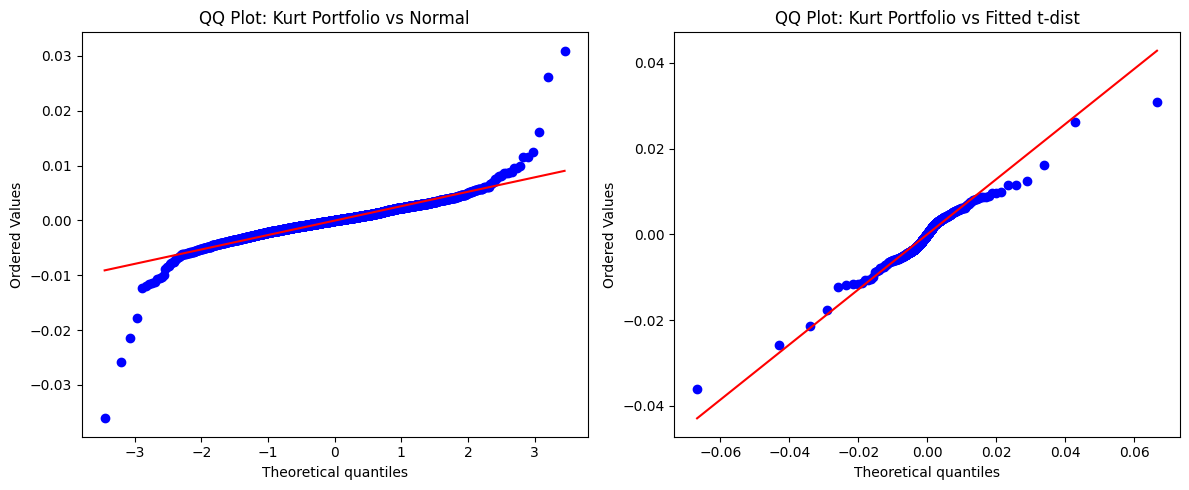


--- Lognormality Test: Skew Portfolio ---
Shapiro-Wilk Test on log(1+Skew Portfolio Returns): Statistic=0.8165, p-value=1.615e-46


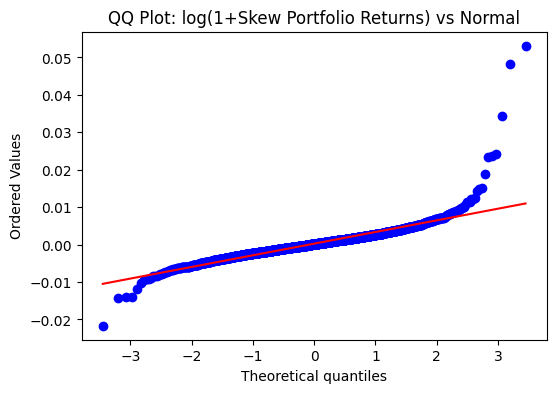


--- Lognormality Test: Kurt Portfolio ---
Shapiro-Wilk Test on log(1+Kurt Portfolio Returns): Statistic=0.8662, p-value=1.293e-41


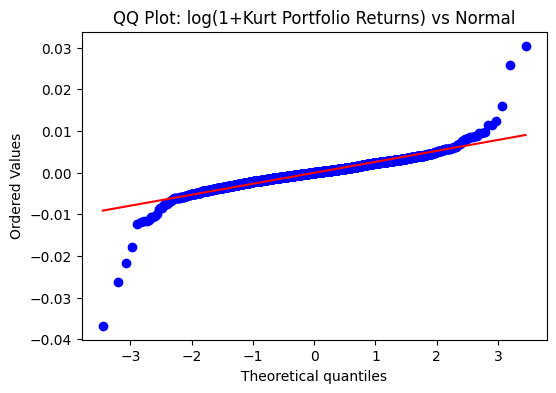

In [58]:
import numpy as np
import pandas as pd
from scipy.stats import t, shapiro
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import scipy.stats as stats
import yfinance as yf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, probplot, t, gaussian_kde
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_tables = pd.read_html(sp500_url)
sp500_df = sp500_tables[0]
tickers = sp500_df['Symbol'].tolist()
tickers = [ticker.replace('.', '-') for ticker in tickers]
print(f"Number of tickers in SP500 universe: {len(tickers)}")
data = pd.read_parquet('sp500_10yr_daily.parquet')

# Fill missing values with forward fill method to preserve more data
data = data.ffill()
print(len(data))

# Calculate log returns
returns = np.log(data / data.shift(1))
print(len(returns))
# Assumed 'returns' DataFrame is already defined (e.g., from yfinance data)
start_date = '2015-01-01'
end_date = '2025-01-01'
filtered_returns = returns.loc[start_date:end_date]

# Weekly hold from paper
formation_window = 5
hold_period = 5

# Shift returns by one day to prevent look-ahead bias
shifted_returns = filtered_returns.shift(1)

rolling_skew = shifted_returns.rolling(window=formation_window).skew()
rolling_kurt = shifted_returns.rolling(window=formation_window).kurt()

portfolio_returns_skew = []
portfolio_returns_kurt = []
formation_dates = []

for i in range(formation_window, len(shifted_returns) - hold_period):
    formation_date = filtered_returns.index[i]
    formation_dates.append(formation_date)
    
    fs = rolling_skew.iloc[i].dropna()
    fk = rolling_kurt.iloc[i].dropna()
    n = len(fs)
    group_size = max(1, int(0.05 * n))
    
    ranked_skew = fs.sort_values()
    long_skew = ranked_skew.index[-group_size:].tolist()
    short_skew = ranked_skew.index[:group_size].tolist()
    weights_skew = pd.Series(0, index=fs.index)
    weights_skew.loc[long_skew] = 1.0 / group_size
    weights_skew.loc[short_skew] = -1.0 / group_size
    
    ranked_kurt = fk.sort_values()
    long_kurt = ranked_kurt.index[-group_size:].tolist()
    short_kurt = ranked_kurt.index[:group_size].tolist()
    weights_kurt = pd.Series(0, index=fk.index)
    weights_kurt.loc[long_kurt] = 1.0 / group_size
    weights_kurt.loc[short_kurt] = -1.0 / group_size
    
    future_returns = filtered_returns.iloc[i:i+hold_period]
    common_skew = weights_skew.index.intersection(future_returns.columns)
    common_kurt = weights_kurt.index.intersection(future_returns.columns)
    if len(common_skew) == 0 or len(common_kurt) == 0:
        continue
    port_ret_skew = future_returns[common_skew].dot(weights_skew[common_skew])
    port_ret_kurt = future_returns[common_kurt].dot(weights_kurt[common_kurt])
    portfolio_returns_skew.append(port_ret_skew.mean())
    portfolio_returns_kurt.append(port_ret_kurt.mean())

portfolio_returns_series_skew = pd.Series(portfolio_returns_skew, index=formation_dates[:len(portfolio_returns_skew)])
portfolio_returns_series_kurt = pd.Series(portfolio_returns_kurt, index=formation_dates[:len(portfolio_returns_kurt)])

plt.figure(figsize=(12, 5))
plt.plot(portfolio_returns_series_skew.cumsum(), label='Skew Portfolio')
plt.plot(portfolio_returns_series_kurt.cumsum(), label='Kurt Portfolio')
plt.legend()
plt.title('Cumulative Returns of Skew and Kurt Portfolios')
plt.show()

def annualized_performance(returns_series, label, risk_free_rate=0.04, trading_days=252):
    mean_daily = returns_series.mean()
    std_daily = returns_series.std()
    annual_return = mean_daily * trading_days
    annual_vol = std_daily * np.sqrt(trading_days)
    annual_sharpe = (annual_return - risk_free_rate) / annual_vol if annual_vol != 0 else np.nan
    print(f"\nAnnualized Performance Metrics: {label}")
    print(f"Annualized Return: {annual_return:.6f}")
    print(f"Annualized Volatility: {annual_vol:.6f}")
    print(f"Annualized Sharpe Ratio: {annual_sharpe:.6f}")

annualized_performance(portfolio_returns_series_skew, "Skew Portfolio", 0.04)
annualized_performance(portfolio_returns_series_kurt, "Kurtosis Portfolio", 0.04)

print("\n--- Analysis: Skew Portfolio Returns ---")
skew_data = portfolio_returns_series_skew.dropna()
shapiro_stat, shapiro_p = shapiro(skew_data)
print(f"Shapiro-Wilk Test (Normality): Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4g}")
params_t = t.fit(skew_data)
print("Fitted t-distribution parameters (Skew Portfolio):")
print("Degrees of freedom, location, scale =", params_t)
adf_result = adfuller(skew_data)
print("\nADF Test (Skew Portfolio Returns):")
print(f"Test Statistic: {adf_result[0]:.4f}, p-value={adf_result[1]:.4g}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(skew_data, dist="norm", plot=plt)
plt.title("QQ Plot: Skew Portfolio vs Normal")
plt.subplot(1, 2, 2)
stats.probplot(skew_data, dist=t, sparams=(params_t[0], params_t[1], params_t[2]), plot=plt)
plt.title("QQ Plot: Skew Portfolio vs Fitted t-dist")
plt.tight_layout()
plt.show()

print("\n--- Analysis: Kurt Portfolio Returns ---")
kurt_data = portfolio_returns_series_kurt.dropna()
shapiro_stat_k, shapiro_p_k = shapiro(kurt_data)
print(f"Shapiro-Wilk Test (Normality): Statistic={shapiro_stat_k:.4f}, p-value={shapiro_p_k:.4g}")
params_t_k = t.fit(kurt_data)
print("Fitted t-distribution parameters (Kurt Portfolio):")
print("Degrees of freedom, location, scale =", params_t_k)
adf_result_k = adfuller(kurt_data)
print("\nADF Test (Kurt Portfolio Returns):")
print(f"Test Statistic: {adf_result_k[0]:.4f}, p-value={adf_result_k[1]:.4g}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(kurt_data, dist="norm", plot=plt)
plt.title("QQ Plot: Kurt Portfolio vs Normal")
plt.subplot(1, 2, 2)
stats.probplot(kurt_data, dist=t, sparams=(params_t_k[0], params_t_k[1], params_t_k[2]), plot=plt)
plt.title("QQ Plot: Kurt Portfolio vs Fitted t-dist")
plt.tight_layout()
plt.show()

# --- Additional Test: Lognormality of the Portfolios ---
# For a variable to be lognormally distributed, log(1 + r) should be normally distributed.
# Make sure that (1 + r) > 0 for each return r. This test applies the Shapiro-Wilk test and plots a QQ plot.

print("\n--- Lognormality Test: Skew Portfolio ---")
# Calculate gross returns and ensure no invalid values (returns > -1)
gross_returns_skew = skew_data[skew_data > -1] + 1
log_returns_skew = np.log(gross_returns_skew)
log_shapiro_stat, log_shapiro_p = shapiro(log_returns_skew)
print(f"Shapiro-Wilk Test on log(1+Skew Portfolio Returns): Statistic={log_shapiro_stat:.4f}, p-value={log_shapiro_p:.4g}")

plt.figure(figsize=(6, 4))
stats.probplot(log_returns_skew, dist="norm", plot=plt)
plt.title("QQ Plot: log(1+Skew Portfolio Returns) vs Normal")
plt.show()

print("\n--- Lognormality Test: Kurt Portfolio ---")
gross_returns_kurt = kurt_data[kurt_data > -1] + 1
log_returns_kurt = np.log(gross_returns_kurt)
log_shapiro_stat_k, log_shapiro_p_k = shapiro(log_returns_kurt)
print(f"Shapiro-Wilk Test on log(1+Kurt Portfolio Returns): Statistic={log_shapiro_stat_k:.4f}, p-value={log_shapiro_p_k:.4g}")

plt.figure(figsize=(6, 4))
stats.probplot(log_returns_kurt, dist="norm", plot=plt)
plt.title("QQ Plot: log(1+Kurt Portfolio Returns) vs Normal")
plt.show()


Average Realized Skewness by Sampling Frequency:
Interval 1 minute(s): 0.0129
Interval 2 minute(s): 0.0134
Interval 5 minute(s): 0.0124
Interval 10 minute(s): 0.0103
Interval 15 minute(s): 0.0025
Interval 30 minute(s): 0.0073
Interval 60 minute(s): -0.0069
Interval 120 minute(s): 0.0017
Interval 240 minute(s): nan
Interval 480 minute(s): nan

Average Realized Excess Kurtosis by Sampling Frequency:
Interval 1 minute(s): 0.6523
Interval 2 minute(s): 0.4332
Interval 5 minute(s): 0.2066
Interval 10 minute(s): 0.1101
Interval 15 minute(s): 0.0769
Interval 30 minute(s): 0.0165
Interval 60 minute(s): -0.0465
Interval 120 minute(s): nan
Interval 240 minute(s): nan
Interval 480 minute(s): nan


c:\Users\jeurc\anaconda3\envs\data-quality\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jeurc\anaconda3\envs\data-quality\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


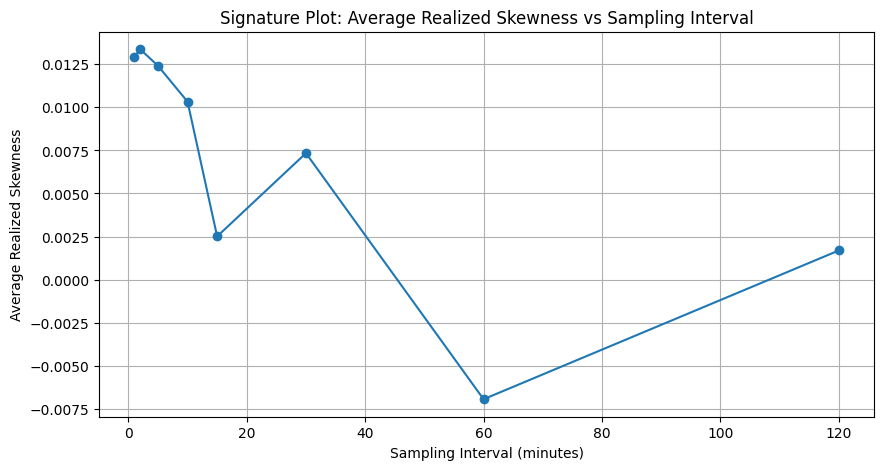

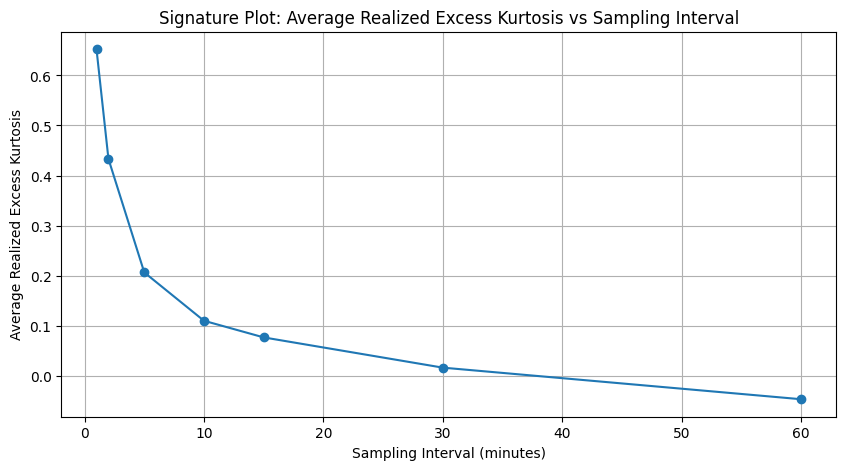

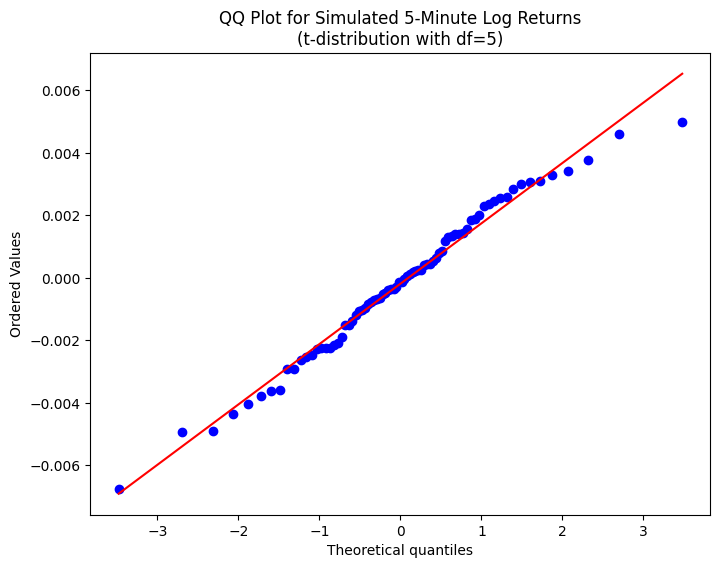

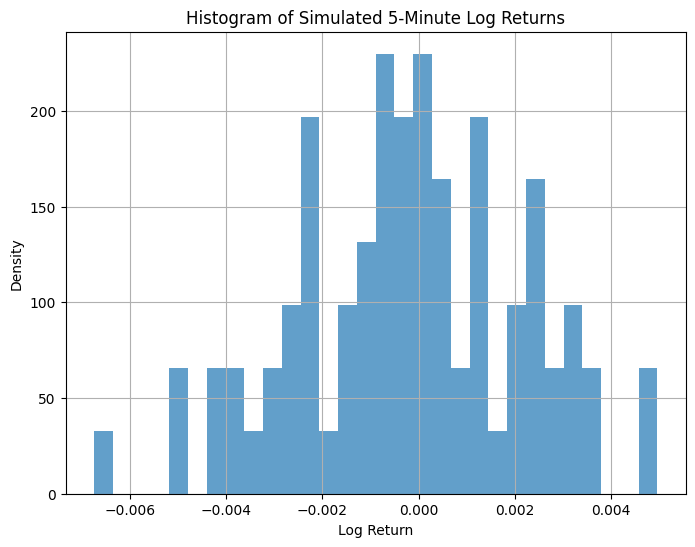

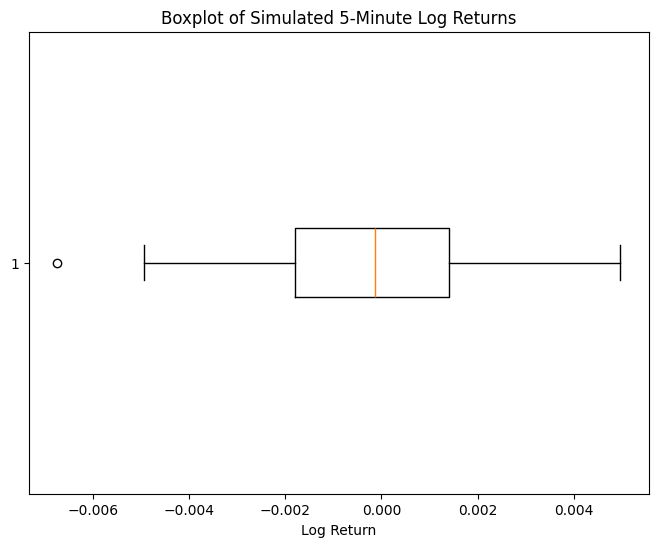

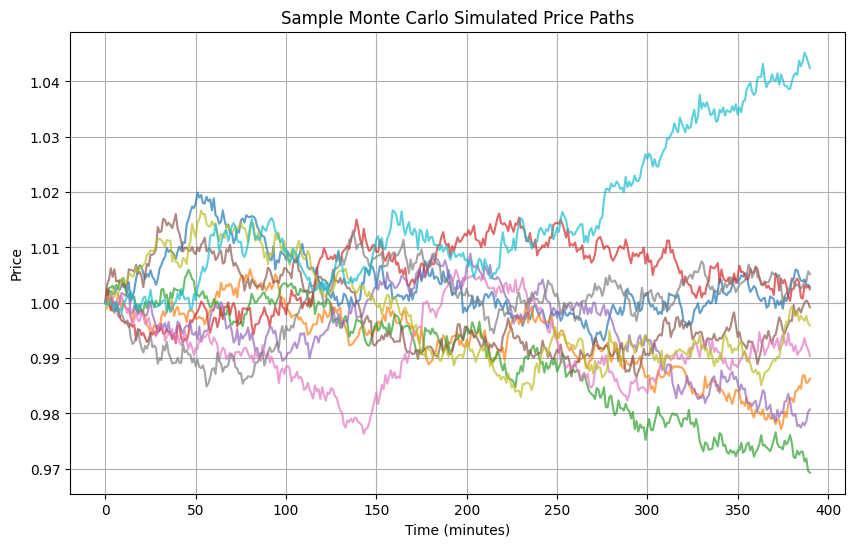

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy import stats

# Monte Carlo simulation parameters
num_paths = 5000      # number of simulated paths
N = 390               # number of minutes in one trading day (approximation)
dt = 1.0              # time step (1 minute)

# Parameters for the continuous (diffusive) part:
mu = 0.0              # drift (per minute)
sigma = 0.001         # volatility per minute (~daily volatility of ~2% over 390 minutes)

# Parameters for the jump component:
lambda_jump = 0.001   # jump intensity per minute (~0.39 jumps per day on average)
jump_mean = 0.0       # average jump size
jump_std = 0.005      # jump size standard deviation

# Microstructure noise standard deviation:
noise_std = 0.0005

def simulate_path(N, mu, sigma, lambda_jump, jump_mean, jump_std, noise_std):
    """
    Simulate a log-price path with jump-diffusion dynamics and add microstructure noise.
    Returns the observed price path (in levels) over N+1 time points.
    """
    logP = np.zeros(N+1)
    for t in range(N):
        dW = np.random.normal(0, np.sqrt(dt))
        # Poisson jump: number of jumps in dt:
        dN = np.random.poisson(lambda_jump * dt)
        jump = np.sum(np.random.normal(jump_mean, jump_std, size=dN)) if dN > 0 else 0.0
        logP[t+1] = logP[t] + mu*dt + sigma*dW + jump
    # Add microstructure noise:
    noise = np.random.normal(0, noise_std, size=N+1)
    observed_logP = logP + noise
    price = np.exp(observed_logP)
    return price

sampling_intervals = [1, 2, 5, 10, 15, 30, 60, 120, 240, 480]

# Dictionaries to store simulated skewness and kurtosis for different sampling intervals.
skew_results = {interval: [] for interval in sampling_intervals}
kurt_results = {interval: [] for interval in sampling_intervals}

for i in range(num_paths):
    price_path = simulate_path(N, mu, sigma, lambda_jump, jump_mean, jump_std, noise_std)
    # For each sampling interval, subsample the price path and compute log returns.
    for interval in sampling_intervals:
        indices = np.arange(0, len(price_path), interval)
        sampled_prices = price_path[indices]
        sampled_returns = np.diff(np.log(sampled_prices))
        if len(sampled_returns) > 0:
            rskew = skew(sampled_returns)
            # Using excess kurtosis (Fisher definition, where 0 corresponds to normal)
            rkurt = pd.Series(sampled_returns).kurtosis()
            skew_results[interval].append(rskew)
            kurt_results[interval].append(rkurt)

avg_skew = {interval: np.mean(skew_results[interval]) for interval in sampling_intervals}
avg_kurt = {interval: np.mean(kurt_results[interval]) for interval in sampling_intervals}

print("Average Realized Skewness by Sampling Frequency:")
for interval in sampling_intervals:
    print(f"Interval {interval} minute(s): {avg_skew[interval]:.4f}")

print("\nAverage Realized Excess Kurtosis by Sampling Frequency:")
for interval in sampling_intervals:
    print(f"Interval {interval} minute(s): {avg_kurt[interval]:.4f}")

# Signature plots for average realized skewness and excess kurtosis
plt.figure(figsize=(10,5))
plt.plot(sampling_intervals, [avg_skew[x] for x in sampling_intervals], marker='o')
plt.title("Signature Plot: Average Realized Skewness vs Sampling Interval")
plt.xlabel("Sampling Interval (minutes)")
plt.ylabel("Average Realized Skewness")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sampling_intervals, [avg_kurt[x] for x in sampling_intervals], marker='o')
plt.title("Signature Plot: Average Realized Excess Kurtosis vs Sampling Interval")
plt.xlabel("Sampling Interval (minutes)")
plt.ylabel("Average Realized Excess Kurtosis")
plt.grid(True)
plt.show()

# --- Additional Distribution Analysis for Simulated Data ---
# For one simulated path, take sampling interval = 5 minutes and generate a QQ plot against a t-distribution.
test_path = simulate_path(N, mu, sigma, lambda_jump, jump_mean, jump_std, noise_std)
indices = np.arange(0, len(test_path), 5)
sampled_prices = test_path[indices]
sampled_returns = np.diff(np.log(sampled_prices))

plt.figure(figsize=(8,6))
# Here we use a t-distribution with an assumed degree of freedom (say, 5) as an example.
stats.probplot(sampled_returns, dist="t", sparams=(5,), plot=plt)
plt.title("QQ Plot for Simulated 5-Minute Log Returns\n(t-distribution with df=5)")
plt.show()

# Plot histogram and boxplot for the sampled 5-minute returns
plt.figure(figsize=(8,6))
plt.hist(sampled_returns, bins=30, alpha=0.7, density=True)
plt.title("Histogram of Simulated 5-Minute Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.boxplot(sampled_returns, vert=False)
plt.title("Boxplot of Simulated 5-Minute Log Returns")
plt.xlabel("Log Return")
plt.show()

# --- New: Plot Sample Monte Carlo Paths ---
# Plot a few sample simulated price paths.
num_sample_paths = 10  # number of sample paths to display
plt.figure(figsize=(10,6))
for i in range(num_sample_paths):
    path = simulate_path(N, mu, sigma, lambda_jump, jump_mean, jump_std, noise_std)
    plt.plot(path, alpha=0.7)
plt.title("Sample Monte Carlo Simulated Price Paths")
plt.xlabel("Time (minutes)")
plt.ylabel("Price")
plt.grid(True)
plt.show()
